## Modeling

My primary angle of approach for our team's dataset is to build a classification model to predict whether a plane is amateur built or not based on other features of the event. As a secondary initiative, I will examine if there is any way to predict which month a crash occurred in based on its features.

#### Skip Ahead:

[Amateur Hour](#Amateur-Hour)  
[Predicting Month](#Predicting-Month)

In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_colwidth', None)
from matplotlib import pyplot as plt

In [2]:
air = pd.read_csv('../Data/clean_air.csv', low_memory=False)

In [205]:
air.head() #preview

,investigation_type,accident_number,event_date,location,country,injury_severity,aircraft_damage,registration_number,make,model,amateur_built,engine_type,purpose_of_flight,total_fatal_injuries,weather_condition,broad_phase_of_flight,event_year,event_month
0,Accident,LAX08FA043,2007-12-30,"Paso Robles, CA",United States,1.0,Substantial,N254SR,cirrus design corp.,sr22,0.0,Reciprocating,Personal,1.0,VMC,MANEUVERING,2007,12
1,Accident,NYC08FA071,2007-12-30,"Cherokee, AL",United States,1.0,Substantial,N109AE,bell,206l-3,0.0,Turbo Shaft,Other Work Use,3.0,VMC,MANEUVERING,2007,12
2,Accident,DFW08LA052,2007-12-29,"Crowley, TX",United States,1.0,Destroyed,N136DG,althouse,raf 2000 gtx,1.0,Reciprocating,Personal,2.0,VMC,MANEUVERING,2007,12
3,Accident,DFW08FA053,2007-12-29,"Venice, LA",United States,1.0,Destroyed,N211EL,bell,206l1,0.0,Turbo Shaft,Unknown,1.0,IMC,APPROACH,2007,12
4,Accident,SEA08LA054,2007-12-28,"Murrieta, CA",United States,0.0,Substantial,N365SX,hein,sonex,1.0,Reciprocating,Personal,0.0,VMC,CRUISE,2007,12


### Amateur Hour

This model will attempt to predict whether a particular crash event involved an amateur_built plane. I would exect such incidents to be more common as the technology to build and test aircraft becomes more readily available and cheaper to access.

In [206]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [207]:
air.columns

Index(['investigation_type', 'accident_number', 'event_date', 'location',
       'country', 'injury_severity', 'aircraft_damage', 'registration_number',
       'make', 'model', 'amateur_built', 'engine_type', 'purpose_of_flight',
       'total_fatal_injuries', 'weather_condition', 'broad_phase_of_flight',
       'event_year', 'event_month'],
      dtype='object')

In [208]:
air['event_date'] = pd.to_datetime(air['event_date'])

In [209]:
air['location_state'] = [air['location'][n][-2:] for n in range(len(air))]

In [254]:
year_dict = dict(air['event_year'].value_counts())

In [258]:
years = [air[air['event_year']==key]['amateur_built'].value_counts(normalize=True) for key, value in year_dict.items()]

In [263]:
years = [years[n][1] for n in range(len(years))]

In [266]:
am_per_year = list(zip(year_dict.keys(), years))

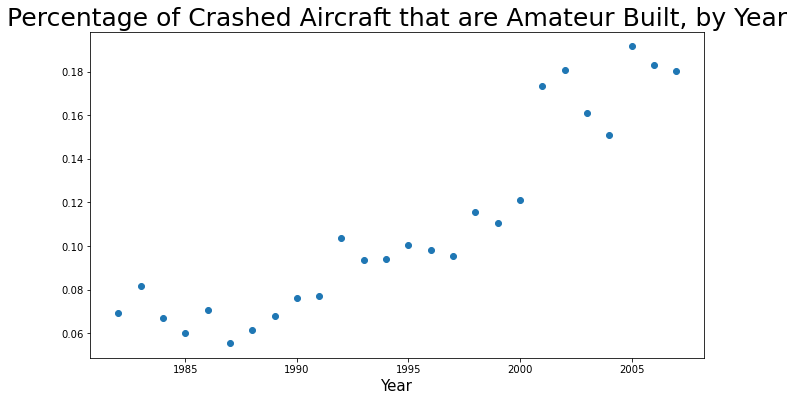

In [287]:
plt.figure(figsize=(11,6))
plt.xlabel('Year', size=15)
plt.scatter(year_dict.keys(), years)
plt.title('Percentage of Crashed Aircraft that are Amateur Built, by Year', size=25);
#plt.savefig('am_by_year.png', dpi=200, bbox_fit='tight')

This plot highlights the importance of addressing amateur built aircraft crashes. The proportion of crashes in our data that are categorized as amateur built rises steadily over time, approaching 20% by the year 2005.

In [210]:
features = ['event_month', 'event_year', 'location_state', 'injury_severity', 
            'weather_condition', 'broad_phase_of_flight', 'aircraft_damage',
           'engine_type', 'purpose_of_flight']
X = air[features]
X = pd.get_dummies(X, columns=['location_state', 'weather_condition', 'broad_phase_of_flight', 'event_month',
                              'aircraft_damage', 'engine_type', 'purpose_of_flight'],
                  drop_first=True)
y =air['amateur_built']

In [211]:
X.shape #potentially problematic distribution...

(50413, 109)

In [212]:
air['amateur_built'].value_counts(normalize=True)

0.0    0.913217
1.0    0.086783
Name: amateur_built, dtype: float64

In [213]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=12, stratify=y)

In [214]:
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)
logreg.score(X_train, y_train)

0.9132217196963686

In [215]:
logreg.score(X_test, y_test)

0.9132021580450651

In [216]:
from sklearn import metrics

In [217]:
preds = logreg.predict(X_test)

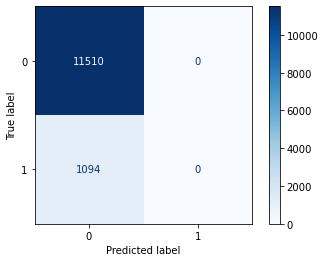

In [219]:
metrics.confusion_matrix(y_test, preds)
metrics.plot_confusion_matrix(logreg, X_test, y_test, cmap='Blues', 
                      values_format='d', display_labels=[0, 1]);
plt.savefig('matrix.png', dpi=200, bbox_fit='tight')

Baseline accuracy (predicting all as not amateur_built) is also 91.32% accurate. My model hasn't really learned anything!  

I'm going to try bootstrapping (random sampling) more amateur built aircraft into my data set to help get a more even distribution.

In [81]:
#referred to lab 4.02

In [220]:
air_am = air[air['amateur_built']==1].copy() #create df of only amateur built events

In [221]:
am_sample = air_am.sample(n=26_000, replace=True, random_state=12)

In [222]:
new_air = pd.concat([air, am_sample])

In [223]:
new_air['amateur_built'].value_counts(normalize=True) 

0.0    0.602489
1.0    0.397511
Name: amateur_built, dtype: float64

Okay, we now have a solid 60/40 split; baseline is now 60% (predicting everything as 0 - not amateur built). Let's see if a model can do better.

In [224]:
features = ['event_month', 'event_year', 'location_state', 'injury_severity', 
            'weather_condition', 'broad_phase_of_flight', 'aircraft_damage',
           'engine_type', 'purpose_of_flight']
X = new_air[features]
X = pd.get_dummies(X, columns=['location_state', 'weather_condition', 'broad_phase_of_flight', 'event_month',
                              'aircraft_damage', 'engine_type', 'purpose_of_flight'],
                  drop_first=True)
y =new_air['amateur_built']

In [225]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=12, stratify=y)

In [226]:
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)
logreg.score(X_train, y_train)

0.7083529637578739

In [227]:
logreg.score(X_test, y_test)

0.7116310720268006

Even though I'm not content with this level of accuracy, I'm going to make a dataframe from the model's coefficients to see what features proved most important to the model's preddictions.

In [228]:
coefs = pd.DataFrame(data=logreg.coef_, columns=X.columns) #create coef dataframe

In [229]:
coefs = coefs.T #transpose

In [230]:
coefs.rename(columns={0:'raw_coef'}, inplace=True)

In [231]:
coefs['abs_coef'] = [abs(x) for x in coefs['raw_coef']]

In [232]:
coefs['exp_coef'] = [np.exp(x) for x in coefs['raw_coef']]

In [233]:
coefs.sort_values(by='exp_coef', ascending=False).head(10)

,raw_coef,abs_coef,exp_coef
weather_condition_VMC,2.075760,2.075760,7.970606
purpose_of_flight_Personal,1.895147,1.895147,6.653523
purpose_of_flight_Unknown,1.278779,1.278779,3.592250
engine_type_Reciprocating,1.108446,1.108446,3.029646
injury_severity,0.785360,0.785360,2.193196
location_state_WI,0.525684,0.525684,1.691616
location_state_FL,0.472971,0.472971,1.604755
location_state_CA,0.433209,0.433209,1.542198
location_state_MI,0.341435,0.341435,1.406965
location_state_OH,0.338472,0.338472,1.402803


These coefficients are somewhat useful in general to see what features are predictive of amateur built planes, however in general the accuracy of 71% is simply not good enough.  

I'm going to evaluate a random forest model next to see how it does:

In [234]:
features = ['event_month', 'event_year', 'location_state', 'injury_severity', 
            'weather_condition', 'broad_phase_of_flight', 'aircraft_damage',
           'engine_type', 'purpose_of_flight']
X = new_air[features]
X = pd.get_dummies(X, columns=['location_state', 'weather_condition', 'broad_phase_of_flight', 'event_month',
                              'aircraft_damage', 'engine_type', 'purpose_of_flight'],
                  drop_first=True)
y =new_air['amateur_built']
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=12, stratify=y)

In [235]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
print(rf.score(X_train, y_train))
rf.score(X_test, y_test)

0.9855694568043414


0.955035594639866

Woah that's an impressive score! Let's see which features were most important:

In [236]:
feat_imp = pd.DataFrame(data=rf.feature_importances_, index=X.columns)

In [237]:
#got help from Hov discovering this method and getting it to work
#https://scikit-learn.org/stable/auto_examples/inspection/plot_partial_dependence.html#sphx-glr-auto-examples-inspection-plot-partial-dependence-py
#https://stackoverflow.com/questions/51814870/resizing-partial-dependency-plots-looks-too-small
#https://scikit-learn.org/stable/auto_examples/miscellaneous/plot_partial_dependence_visualization_api.html#sphx-glr-auto-examples-miscellaneous-plot-partial-dependence-visualization-api-py
from sklearn.inspection import plot_partial_dependence

In [238]:
fi_dict = dict(feat_imp[0].sort_values(ascending=False).head(10))

In [239]:
#for key, value in fi_dict.items():
    #print(plot_partial_dependence(rf, X_train, [key], n_jobs=8));

The code above displayed the individual partial dependence graphs for each of my 10 largest values in the feature importance output; I saw immediately that 5 had a postitive slope and 5 had a negative slope so I decided to replot them in two blocks - positive and negative (below):

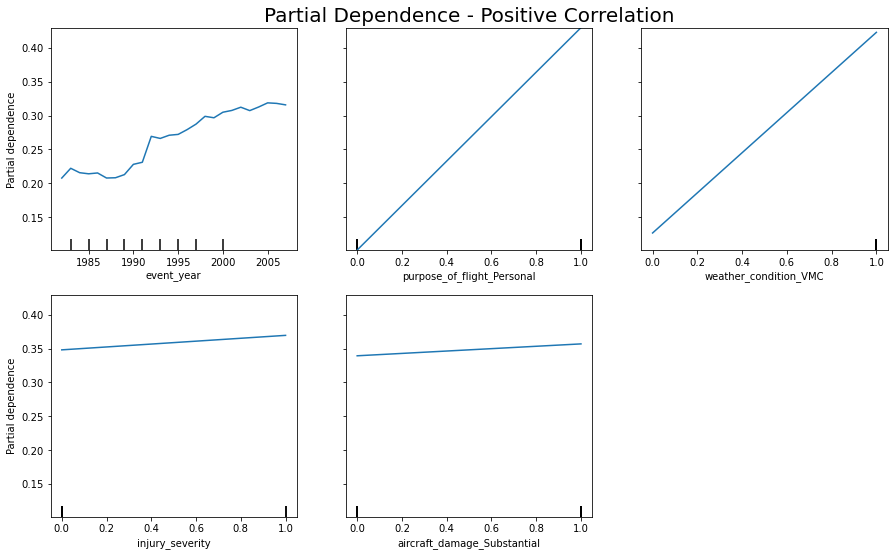

In [247]:
fig, ax = plt.subplots(figsize=(15,9))
ax.set_title('Partial Dependence - Positive Correlation', size=20)
plot_partial_dependence(rf, X_train, [key for key in list(fi_dict.keys())[:5]], n_jobs=8, ax=ax); #positive
#plt.savefig('partial_pos.png', dpi=200, bbox_fit='tight')

As we see here in the top left plot, as time progresses, the year becomes more and more correlated to an event involving an amateur built plane. We also see in the next two graphs that if an event involves a personal flight or visually clear weather conditions, it is more likely to be amateur built. The lower two plots show that higher injury severity (death = 1) and "substantial" aircraft damage are slightly indicative of an amateur built aircraft.

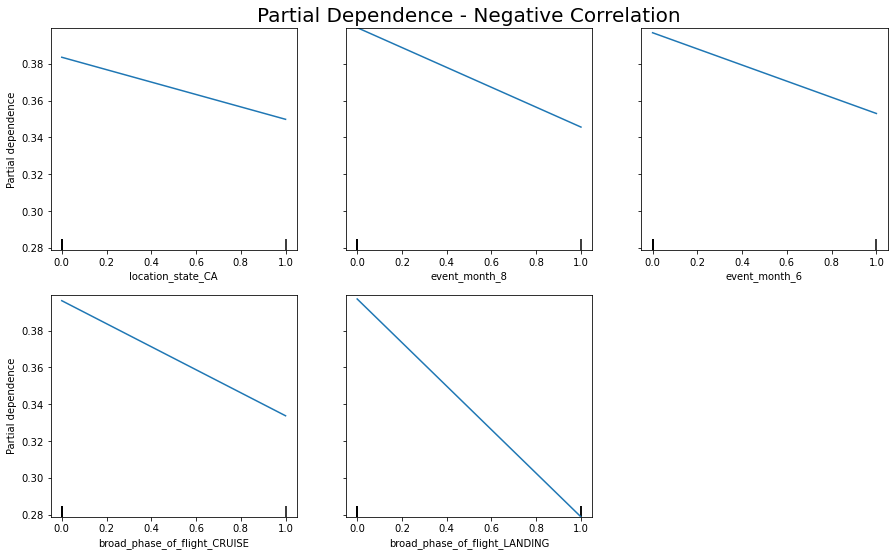

In [241]:
fig, ax = plt.subplots(figsize=(15,9))
ax.set_title('Partial Dependence - Negative Correlation', size=20)
plot_partial_dependence(rf, X_train, [key for key in list(fi_dict.keys())[5:]], n_jobs=8, ax=ax); #negative
#plt.savefig('partial_neg.png', dpi=200, bbox_fit='tight')

In this plot, we see that if a crash is in California it is slightly less likely to involve an amateur-built aircraft. This is also true for crashes occurring in August or June. Finally, amateur built aircraft are less likely to be involved when an event happens during the cruise or landing phase of flight.

[0.0    0.941885
1.0    0.058115
Name: amateur_built, dtype: float64, 0.0    0.935505
1.0    0.064495
Name: amateur_built, dtype: float64, 0.0    0.92661
1.0    0.07339
Name: amateur_built, dtype: float64, 0.0    0.901679
1.0    0.098321
Name: amateur_built, dtype: float64, 0.0    0.90911
1.0    0.09089
Name: amateur_built, dtype: float64, 0.0    0.902526
1.0    0.097474
Name: amateur_built, dtype: float64, 0.0    0.894114
1.0    0.105886
Name: amateur_built, dtype: float64, 0.0    0.910786
1.0    0.089214
Name: amateur_built, dtype: float64, 0.0    0.909226
1.0    0.090774
Name: amateur_built, dtype: float64, 0.0    0.908973
1.0    0.091027
Name: amateur_built, dtype: float64, 0.0    0.922414
1.0    0.077586
Name: amateur_built, dtype: float64, 0.0    0.934917
1.0    0.065083
Name: amateur_built, dtype: float64]


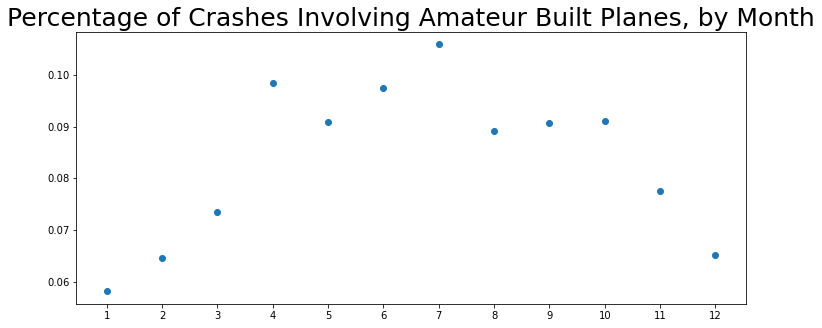

In [290]:
months = list(range(1,13))
all_months = [air[air['event_month'] == month]['amateur_built'].value_counts(normalize=True) for month in months]
print(all_months)
all_months = [all_months[n][1] for n in range(len(all_months))]
plt.figure(figsize=(12,5))
plt.scatter(months, all_months)
plt.title('Percentage of Crashes Involving Amateur Built Planes, by Month', size=25)
plt.xticks(ticks=months);

This graph shows amateur built aircraft crashes as a proportion of all crashes by month; we can see that July is the most frequent at about 10.5%, with April second at around 10%. Given the easy illiteration of "Amateur April", I recommend creating a safety campaign for amateur building enthusiasts during that month.

### Predicting Month

I'm interested to see if any features or combinations of features point to which month the event occurred. This may not be the case but it would be interesting if there were a strong predictive element.

In [44]:
air.columns

Index(['investigation_type', 'accident_number', 'event_date', 'location',
       'country', 'injury_severity', 'aircraft_damage', 'registration_number',
       'make', 'model', 'amateur_built', 'engine_type', 'purpose_of_flight',
       'total_fatal_injuries', 'weather_condition', 'broad_phase_of_flight',
       'event_year', 'event_month', 'location_state'],
      dtype='object')

In [45]:
features = ['investigation_type', 'injury_severity', 'aircraft_damage', 'make', 'model', 'amateur_built',
           'engine_type', 'purpose_of_flight', 'weather_condition', 'broad_phase_of_flight', 'event_year', 'location_state']
X = air[features]
X = pd.get_dummies(X, columns=['investigation_type', 'aircraft_damage', 'make', 'model', 'engine_type',
                              'purpose_of_flight', 'weather_condition', 'broad_phase_of_flight', 'location_state'])
y = air['event_month']

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=12, stratify=y)

I'll start with a Random Forest Classification model -- this should be able to handle our multivariate classification problem (12 months). I'll do a wide grid-search to see if there is any combination of hyperparameters that provides decent prediction accuracy.

``` Python
rf = RandomForestClassifier()
rf_params = {
    'n_estimators':[100,125,150],
    'max_depth':[None, 100],
    'min_samples_split':[2,4],
    'min_samples_leaf':[1,4],
    'max_features':['auto']
}
rf_gs = GridSearchCV(rf, rf_params, n_jobs=8, verbose=1)
rf_gs.fit(X_train, y_train)
print(f' Training Score: {rf_gs.best_estimator_.score(X_train, y_train)}')
print(f' Test Score: {rf_gs.best_estimator_.score(X_test, y_test)}')
print(f' Best params: {rf_gs.best_params_}')
```

``` Python
Fitting 5 folds for each of 24 candidates, totalling 120 fits
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed: 31.5min
[Parallel(n_jobs=8)]: Done 120 out of 120 | elapsed: 62.4min finished
 Training Score: 0.1846385781163215
 Test Score: 0.12884798476674073
 Best params: {'max_depth': 100, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
```

Well, despite the grid search, month prediction accuracy appears to be extremely poor!  

As a reminder- the baseline prediction accuracy would be .12 or 12% (predicting every accident to be in July), as shown below:

| month  |   value_counts (normalized) |
|---:|--------------:|
|  7 |     0.120643  |
|  8 |     0.11384   |
|  6 |     0.106024  |
|  5 |     0.096245  |
|  9 |     0.0937457 |
|  4 |     0.0827168 |
| 10 |     0.07627   |
|  3 |     0.0751393 |
| 11 |     0.0621268 |
|  2 |     0.0596671 |
| 12 |     0.0576042 |
|  1 |     0.0559776 |

For the sake of completeness, we'll do a simple Logistic Regression on the same data and see if that proves better at predicting event_month:

``` Python
logreg = LogisticRegression(max_iter=500)
logreg.fit(X_train, y_train)
print(f'Train score: {logreg.score(X_train, y_train)}')
print(f'Test score: {logreg.score(X_test, y_test)}')

Train score: 0.1310005554233119
Test score: 0.1259124087591241
    
```

Slight overfit but both scores are barely better than baseline. There doesn't seem to be any clear predictive connection between accident/incident details and the month they happened, however, given more time and data (perhaps with more features created from incident reports), I would like to explore this problem further.